In [2]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.geometry import Point
calculated_pair_path = "data/node_pairs.parquet"

In [4]:
def compute_distance(row, graph):
    try:
        return nx.shortest_path_length(graph, row['prev_osmid'], row['osmid'], weight='length')
    except nx.NetworkXNoPath:
        return None
    
def compute_path(row, graph):
    try:
        return nx.shortest_path(graph, row['prev_osmid'], row['osmid'], weight='length')
    except nx.NetworkXNoPath:
        return None
    
def compute_euclid_dists(node_pairs, nodes_points):
    nodes_points = nodes_points.to_crs(2263)
    nodes_points["x"] = nodes_points["geometry"].x
    nodes_points["y"] = nodes_points["geometry"].y

    node_pairs = node_pairs.merge(nodes_points, left_on = "osmid", right_on = "osmid", how = "left").merge(nodes_points, right_on = "osmid", left_on = "prev_osmid", how = "left", suffixes = ["curr", "prev"])
    node_pairs["x_diff_sq"] = (node_pairs["xcurr"] - node_pairs["xprev"])**2
    node_pairs["y_diff_sq"] = (node_pairs["ycurr"] - node_pairs["yprev"])**2

    return (node_pairs["x_diff_sq"] + node_pairs["y_diff_sq"]) ** (1/2) / 3.28

def compute_euclid_dists(node_pairs, nodes_points):
    nodes_points = nodes_points.to_crs(2263)
    nodes_points["x"] = nodes_points["geometry"].x
    nodes_points["y"] = nodes_points["geometry"].y

    node_pairs = node_pairs.merge(nodes_points, left_on = "osmid", right_on = "osmid", how = "left").merge(nodes_points, right_on = "osmid", left_on = "prev_osmid", how = "left", suffixes = ["curr", "prev"])
    node_pairs["x_diff_sq"] = (node_pairs["xcurr"] - node_pairs["xprev"])**2
    node_pairs["y_diff_sq"] = (node_pairs["ycurr"] - node_pairs["yprev"])**2

    return (node_pairs["x_diff_sq"] + node_pairs["y_diff_sq"]) ** (1/2) / 3.28

def precalculate_node_pair_distances(node_pair_df, calculated_pair_path, G, nodes):
    try:
        calculated_pairs = pd.read_parquet(calculated_pair_path)
    except:
        print("No pre-calulated pairs found")
        calculated_pairs = pd.DataFrame(columns = ["osmid", "prev_osmid", "distance_osm", "distance_euclid", "shortest_path", "dist_ratio"])

    node_pair_df = node_pair_df.drop_duplicates().dropna()
    node_pair_df = node_pair_df.merge(calculated_pairs, on=["osmid", "prev_osmid"], how="outer")
    pairs_to_calc = node_pair_df.query("distance_euclid.isna()").reset_index(drop = True)
    print(pairs_to_calc.shape)
    
    if pairs_to_calc.shape[0] > 0:
        pairs_to_calc["distance_osm"] = pairs_to_calc.apply(compute_distance, graph=G, axis=1)
        pairs_to_calc["distance_euclid"] = compute_euclid_dists(pairs_to_calc, nodes) 
        pairs_to_calc["shortest_path"] = pairs_to_calc.apply(compute_path, graph=G, axis=1)

        pairs_to_calc["dist_ratio"] = pairs_to_calc["distance_euclid"] / pairs_to_calc["distance_osm"]

        calculated_pairs = pd.concat([calculated_pairs, pairs_to_calc])
        calculated_pairs.to_parquet(calculated_pair_path)
        print(f"Wrote calculated pairs to {calculated_pair_path}")
    else:
        print("No new pairs to calculate")

def prep_buses_nodes(buses_with_nodes, max_distance_to_node):

    buses_with_nodes = buses_with_nodes.sort_values(["trip_id", "timestamp"]).drop_duplicates(subset = ["trip_id", "osmid"],  keep = "first").to_crs(2263)
    buses_with_nodes = buses_with_nodes[["route", "timestamp", "trip_id", "osmid", "vehicle_id", "distance_to_node", "geometry"]]
    buses_with_nodes["prev_osmid"] = buses_with_nodes.groupby("trip_id")["osmid"].shift(1)
    buses_with_nodes["next_osmid"] = buses_with_nodes.groupby("trip_id")["osmid"].shift(-1)

    buses_with_nodes["prev_osmid"] = buses_with_nodes["prev_osmid"].astype(float)
    buses_with_nodes["osmid"] = buses_with_nodes["osmid"].astype(float)

    buses_with_nodes = buses_with_nodes.query("distance_to_node < @max_distance_to_node")

    return buses_with_nodes

def calculate_segment_speeds():
    pass

def explode_route_segments():
    pass

def drop_wrong_nodes():
    pass

def tag_feed_with_nodes(buses, tree, nodes, types_to_include = [np.NaN, "traffic_signals", "stop"]):
    nodes = nodes[nodes["highway"].isin(types_to_include)]
    nearest_nodes = tree.query(np.array(buses[['lat', 'lon']]), k=1, return_distance=False)
    buses['nearest_node'] = nearest_nodes.flatten()

    # Map node IDs to OSM IDs
    buses['nearest_osm_id'] = buses['nearest_node'].map(nodes['osmid'])
    buses = buses.merge(nodes, left_on = "nearest_osm_id", right_on = "osmid")
    buses = gpd.GeoDataFrame(buses, geometry='geometry')

    return buses

def get_node_data(place = "New York City, New York, USA"):
    G = ox.graph_from_place(place, network_type='drive')

    # Convert graph nodes to a DataFrame for KDTree
    nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
    tree = KDTree(nodes[['y', 'x']], metric='euclidean')

    return tree, nodes, G

def prep_coords(df, lat_col, lon_col):

    df['geometry'] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs(4326)

    gdf["planar_x"] = gdf.to_crs(2263).geometry.x
    gdf["planar_y"] = gdf.to_crs(2263).geometry.y
    
    gdf = gdf.drop('geometry', axis = 1)
    return gdf

def calculate_distance_to_node(buses_with_nodes):

    out = ((buses_with_nodes.to_crs(2263).geometry.x - buses_with_nodes["planar_x"])**2 + (buses_with_nodes.to_crs(2263).geometry.y - buses_with_nodes["planar_y"])**2)**(1/2)

    return out

def calculate_speeds(prepped_trips, calculated_pair_path = "data/node_pairs.parquet", minimum_time_diff = 45):
    
    node_pair_dists = pd.read_parquet(calculated_pair_path)

    prepped_trips["time_diff_seconds"] = prepped_trips.groupby("trip_id")["timestamp"].diff().dt.total_seconds()
    prepped_trips = prepped_trips.query("time_diff_seconds >= @minimum_time_diff")

    buses_with_distances = prepped_trips.merge(node_pair_dists)
    buses_with_distances["speed_osm"] = (buses_with_distances["distance_osm"] / 1609) / (buses_with_distances["time_diff_seconds"] / 3600)
    buses_with_distances["speed_euclid"] = (buses_with_distances["distance_euclid"] / 1609) / (buses_with_distances["time_diff_seconds"] / 3600)
    
    return buses_with_distances

def explode_edges(row):
    try:
        nodes = row['shortest_path']
        idxs = [int(row['index'])]*(len(nodes)-1)
        osmids = nodes[1:len(nodes)]
        prev_osmids = nodes[0:len(nodes)-1]        
        d = pd.DataFrame(data={'idx':idxs,'from':prev_osmids,'to':osmids})
    except:
        d = pd.DataFrame(data={'idx':[pd.NA],'from':[pd.NA],'to':[pd.NA]})
    
    return d


In [7]:
GTFS_PATH = "https://urbantech-public.s3.amazonaws.com/DO-NOT-DELETE-BUSOBSERVATORY-PUBLIC-DATASET/one-system-day.tar.gz"
CALCULATED_PAIR_PATH = "data/node_pairs.parquet"
OUT_PATH = "data/buses_with_segmented.parquet"

In [9]:
read_parquet_from_tar_gz(GTFS_PATH).columns

Index(['route', 'timestamp', 'route_long', 'direction', 'service_date',
       'trip_id', 'gtfs_shape_id', 'route_short', 'agency', 'origin_id',
       'destination_name', 'next_stop_id', 'next_stop_eta',
       'next_stop_d_along_route', 'next_stop_d', 'lat', 'lon', 'bearing',
       'progress_rate', 'vehicle_id', 'gtfs_block_id', 'passenger_count',
       'progress_status'],
      dtype='object')

In [6]:
tree, nodes, G = get_node_data()

In [7]:
def process_gtfs_rt_main(tree, nodes, G, gtfs_path, calculated_pair_path, out_path):

    print("Preprocssing bus data")
    buses = read_parquet_from_tar_gz(gtfs_path)
    buses = prep_coords(buses, 'lat', 'lon')

    print("Tagging bus locations with nodes")
    buses_with_nodes = tag_feed_with_nodes(buses, tree, nodes)
    buses_with_nodes["distance_to_node"] = calculate_distance_to_node(buses_with_nodes)

    print("Calculating distance pairs")
    prepped_trips = prep_buses_nodes(buses_with_nodes, max_distance_to_node = 150)
    node_pair_df = prepped_trips[["osmid", "prev_osmid"]]

    precalculate_node_pair_distances(node_pair_df, calculated_pair_path, G, nodes)
    buses_with_speeds = calculate_speeds(prepped_trips).reset_index()

    print("Exploding edges")
    dfs = []
    for i,row in buses_with_speeds.iterrows():
        dfs.append(explode_edges(row))

    segment_speeds = pd.concat(dfs)
    bus_speed_segemented = buses_with_speeds.merge(segment_speeds, left_on = "index", right_on = "idx").drop(["index"], axis = 1)

    print("Writing to parquet")
    bus_speed_segemented.to_parquet(out_path)

In [8]:
process_gtfs_rt_main(tree, nodes, G, GTFS_PATH, CALCULATED_PAIR_PATH, OUT_PATH)

Preprocssing bus data


KeyboardInterrupt: 

<Axes: >

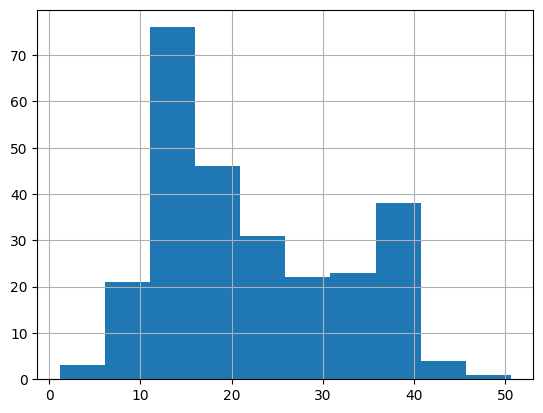

In [47]:
bus_speed_segemented.query("speed_osm < 70").query("`from` == 4209661118 & to == 4209661121.00")['speed_osm'].hist()

In [23]:
segment_speeds.to_parquet("segments_test.parquet")

In [ ]:
prepped_trips["time_diff_seconds"] = prepped_trips.groupby("trip_id")["timestamp"].diff().dt.total_seconds()